# Appendix

### Movie Rating Prediction Project Code

In [2]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Load movies data
movies = pd.read_csv('movies.csv')
# Load ratings data
rating = pd.read_csv('ratings.csv')
#Load tags data
tags = pd.read_csv('tags.csv')
#Join together movies and ratings datasets
df = pd.merge(movies, rating, on=['movieId'])
#Join together combined movies and ratings with tags
df = pd.merge(df, tags, on=['movieId'])
df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,336,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,474,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,567,fun,1525286013
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,336,pixar,1139045764
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,474,pixar,1137206825


In [3]:
#Check for any missing values with any of the variables
df.isna().sum()

movieId        0
title          0
genres         0
userId_x       0
rating         0
timestamp_x    0
userId_y       0
tag            0
timestamp_y    0
dtype: int64

In [4]:
# Create new dataframe using bag of words for the genres column
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
x = v.fit_transform(df['genres'])
x = pd.DataFrame.sparse.from_spmatrix(x, columns = v.get_feature_names())
x.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Add timestamp to the bag of words features - extract year and month of rating and tag and add as two separate variables
features = x
#Rating
features['rating_year'] = pd.to_datetime(df['timestamp_x'], unit = 's').dt.year
features['rating_month'] = pd.to_datetime(df['timestamp_x'], unit = 's').dt.month
#Tag
features['tag_year'] = pd.to_datetime(df['timestamp_y'], unit = 's').dt.year
features['tag_month'] = pd.to_datetime(df['timestamp_y'], unit = 's').dt.month
#Extract year the movie was released as another feature
features['release_year'] = df['title'].str.extract('(\d+)')
#Check for missing values
features.isna().sum()
#Find out which movie has a missing year value
df['release_year'] = df['title'].str.extract('(\d+)')
missing_vals = df[df.isnull().any(axis = 1)]
missing_vals
#Movie was released in 2016, so fill in missing values with 2016 in the features dataframe
features = features.fillna(2016)
features['release_year'] = features['release_year'].astype('int')

In [6]:
#Encode the tags feature and add to the dataframe
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
features['tags'] = le.fit_transform(df['tag'])

In [7]:
features.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,sci,thriller,war,western,rating_year,rating_month,tag_year,tag_month,release_year,tags
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,2000,7,2006,2,1995,1239
1,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,2000,7,2006,1,1995,1239
2,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,2000,7,2018,5,1995,930
3,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,1996,11,2006,2,1995,1239
4,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,1996,11,2006,1,1995,1239


In [106]:
features.rename(columns = {'fi':'scifi'}, inplace = True)
#features = features.drop('sci', axis = 1)
#Plot count of each genre - which genre is most frequently seen?
genre_sums = pd.DataFrame(features.iloc[:,0:23].sum(axis = 0), columns = ['Count'])
genre_sums

,Count
action,69549
adventure,47939
animation,10466
children,11595
comedy,96901
crime,103102
documentary,711
drama,148389
fantasy,16220
scifi,51977


<AxesSubplot:xlabel='release_year', ylabel='Count'>

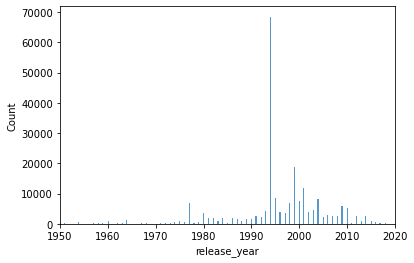

In [109]:
#Plot most common release year
import seaborn as sns
year_plot = sns.histplot(features['release_year'])
year_plot.set(xlim=(1950, 2020))
year_plot

In [8]:
y = df['rating'].astype('int')

<AxesSubplot:xlabel='rating', ylabel='Count'>

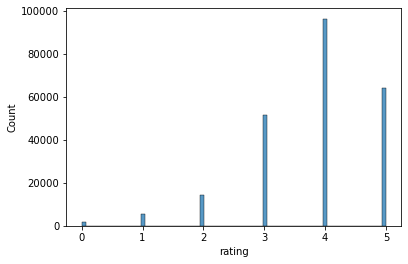

In [9]:
import seaborn as sns
sns.histplot(y)

In [20]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
#Round the ratings up to the nearest whole digit
y_class = [int(round(x)) for x in y]

clf = Perceptron(tol=1e-3, random_state=0)
scores = cross_val_score(clf, features, y_class, cv = 5)
scores.mean()

0.3378841462717353

In [21]:
from sklearn.tree import DecisionTreeClassifier

#Fit decision tree classifier
clf = DecisionTreeClassifier(random_state = 0)
scores = cross_val_score(clf, features, y_class, cv = 5)
scores.mean()

0.1880461898499629

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

Classification report

In [ ]:
rng = np.random.RandomState(0)
X = rng.randn(233213, 1000 )
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

xtr,xts,ytr,yts = t(x,y, test_size = 0.3)
clf = Perceptron()
clf.fit(xtr, ytr)
preds = clf.predict(xts)
metrics.accuracy_score(yts, preds)

In [ ]:

xtr,xts,ytr,yts = t(x,y, test_size = 0.3)
clf = Perceptron()
clf.fit(xtr, ytr)
preds = clf.predict(xts)
metrics.accuracy_score(yts, preds)

In [53]:
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,solver='adam', activation='logistic',verbose=10, 
                    random_state=1,learning_rate_init=.1)
clf.fit(xtr, ytr)
clf.score(xtr, ytr)

Iteration 1, loss = 1.36822172
Iteration 2, loss = 1.36297391
Iteration 3, loss = 1.36228281
Iteration 4, loss = 1.36261905
Iteration 5, loss = 1.36328780
Iteration 6, loss = 1.36427294
Iteration 7, loss = 1.36349889
Iteration 8, loss = 1.36772790
Iteration 9, loss = 1.36309166
Iteration 10, loss = 1.36281652
Iteration 11, loss = 1.36598779
Iteration 12, loss = 1.37159431
Iteration 13, loss = 1.36701470
Iteration 14, loss = 1.37016083
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


0.41244969341312965

In [47]:
y_pred = clf.predict(xts)
acc = accuracy_score(yts, y_pred)
print('Accuracy:', acc)

Accuracy: 0.41379852495569147


In [48]:
def plot_performance(list_, x_label,x_axis):
    
    accuracies = []
    for i in list_:
        clf = i
        clf.fit(xtr, ytr)
        y_pred = clf.predict(xts)
        acc= accuracy_score(yts, y_pred)
        accuracies.append(acc)
    plt.plot(x_label, accuracies,marker='o')
    plt.xlabel(x_axis)
    plt.ylabel('Accuracy')
        
    ind = np.argmax(accuracies)
    print('best parameter: ',x_label[ind],'with accuracy: ',np.max(accuracies))

best parameter:  sgd with accuracy:  0.41379852495569147


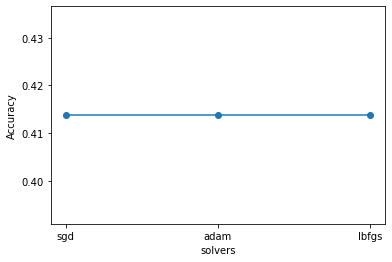

In [49]:
solvers = [MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,solver='sgd', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,solver='adam', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1)]

solver =['sgd','adam','lbfgs']

plot_performance(solvers, solver, 'solvers')

best parameter:  1 with accuracy:  0.41379852495569147


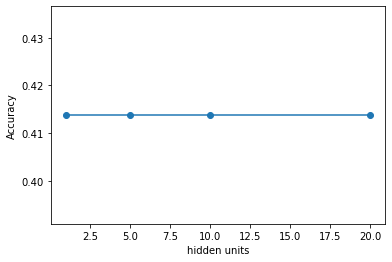

In [59]:
HU  = [MLPClassifier(hidden_layer_sizes=(1,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(5,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1)]

hidden_units = [1,5,10,20]

plot_performance(HU, hidden_units, 'hidden units')

best parameter:  logistic with accuracy:  0.41379852495569147


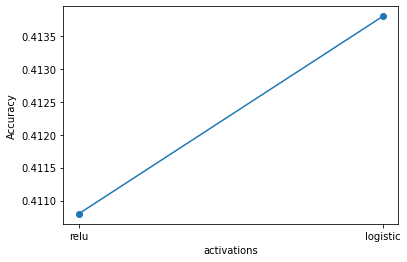

In [51]:
activations= [MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='relu',verbose=False, random_state=1,learning_rate_init=.1),
MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, alpha=1e-4,solver='lbfgs', activation='logistic',verbose=False, random_state=1,learning_rate_init=.1)]

activation = ['relu','logistic']

plot_performance(activations, activation,'activations')

In [56]:
param_accu = []

for i in solver:
    for j in hidden_units:
        for k in activation:
            clf = MLPClassifier(hidden_layer_sizes=(j,), max_iter=100, alpha=1e-4,solver=i, activation=k,verbose=False, random_state=1,learning_rate_init=.1)
            clf.fit(xtr, ytr)
            y_pred = clf.predict(xts)
            acc = accuracy_score(yts, y_pred)
            
            param_accu.append((i,j,k,acc))

In [57]:
len(param_accu)

24

In [58]:
param_accu

[('sgd', 10, 'relu', 0.41379852495569147),
 ('sgd', 10, 'logistic', 0.41379852495569147),
 ('sgd', 50, 'relu', 0.41379852495569147),
 ('sgd', 50, 'logistic', 0.41379852495569147),
 ('sgd', 100, 'relu', 0.41379852495569147),
 ('sgd', 100, 'logistic', 0.2196129437996684),
 ('sgd', 200, 'relu', 0.41379852495569147),
 ('sgd', 200, 'logistic', 0.41379852495569147),
 ('adam', 10, 'relu', 0.41379852495569147),
 ('adam', 10, 'logistic', 0.41379852495569147),
 ('adam', 50, 'relu', 0.41379852495569147),
 ('adam', 50, 'logistic', 0.41379852495569147),
 ('adam', 100, 'relu', 0.41379852495569147),
 ('adam', 100, 'logistic', 0.41379852495569147),
 ('adam', 200, 'relu', 0.41379852495569147),
 ('adam', 200, 'logistic', 0.2743267966382711),
 ('lbfgs', 10, 'relu', 0.41379852495569147),
 ('lbfgs', 10, 'logistic', 0.41379852495569147),
 ('lbfgs', 50, 'relu', 0.41379852495569147),
 ('lbfgs', 50, 'logistic', 0.41379852495569147),
 ('lbfgs', 100, 'relu', 0.41379852495569147),
 ('lbfgs', 100, 'logistic', 0.41

Confusion matrix:


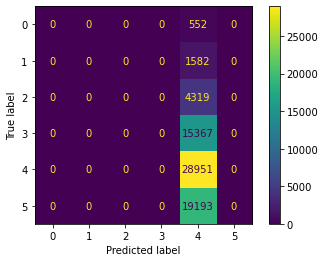

In [62]:
#Plot the confusion matrix for the best model
best_nnet = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, alpha=1e-4,
                          solver='lbfgs', activation='logistic',verbose=False, 
                          random_state=1,learning_rate_init=.1)
best_nnet.fit(xtr, ytr)
y_pred = clf.predict(xts)
print('Confusion matrix:')
plot_confusion_matrix(best_nnet, xts, yts)
plt.show()

In [ ]:
print(classification_report(yts, y_pred))

In [64]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import ensemble
import numpy as np

clf = RandomForestClassifier(criterion = 'entropy')
clf.fit(xtr, ytr)
y_pred = clf.predict(xts)
acc = accuracy_score(yts, y_pred)
print('Accuracy:', acc)

Accuracy: 0.5433508661597393


Confusion matrix:


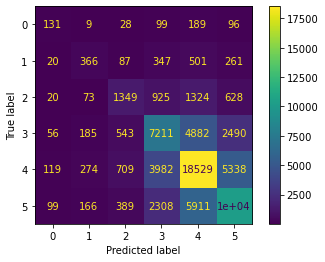

In [63]:
print('Confusion matrix:')
plot_confusion_matrix(clf, xts, yts)
plt.show()

In [ ]:
print(classification_report(yts, y_pred))